In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
df = pd.read_csv('/Users/xiaoming/Library/CloudStorage/OneDrive-AsiaPacificUniversity/Degree Y3S2/FYP/retail_store_inventory.csv')

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [11]:
X = df.drop(['Demand Forecast', 'Date'], axis=1)
y = df['Demand Forecast']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [13]:
categorical_features = [
    'Store ID', 'Product ID', 'Category', 'Region',
    'Weather Condition', 'Holiday/Promotion', 'Seasonality'
]

numerical_features = [
    'Inventory Level', 'Units Sold', 'Units Ordered',
    'Price', 'Discount', 'Competitor Pricing',
    'Day', 'Month', 'Year', 'DayOfWeek'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [14]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Scale target
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [15]:
X_train_rnn = X_train_preprocessed.reshape(
    (X_train_preprocessed.shape[0], 1, X_train_preprocessed.shape[1])
)

X_test_rnn = X_test_preprocessed.reshape(
    (X_test_preprocessed.shape[0], 1, X_test_preprocessed.shape[1])
)

In [16]:
model = Sequential()
model.add(SimpleRNN(
    32,
    input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
    return_sequences=False
))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_rnn,
    y_train_scaled,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


/Users/xiaoming/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


731/731 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - loss: 0.4398 - val_loss: 0.0196
Epoch 2/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.0558 - val_loss: 0.0120
Epoch 3/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.0352 - val_loss: 0.0098
Epoch 4/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 0.0277 - val_loss: 0.0095
Epoch 5/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.0231 - val_loss: 0.0097
Epoch 6/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 0.0205 - val_loss: 0.0082
Epoch 7/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.0190 - val_loss: 0.0103
Epoch 8/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.0175 - val_loss: 0.0087
Epoch 9/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 0.0165 - val_loss: 0.0096
Epoch 10/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 0.0159 - val_loss: 0.0083
Epoch 11/50
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.0151 - val_loss: 0.0082


In [17]:
y_pred_scaled = model.predict(X_test_rnn)
y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


In [18]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 9.89
MAE: 8.28
R²: 0.9917


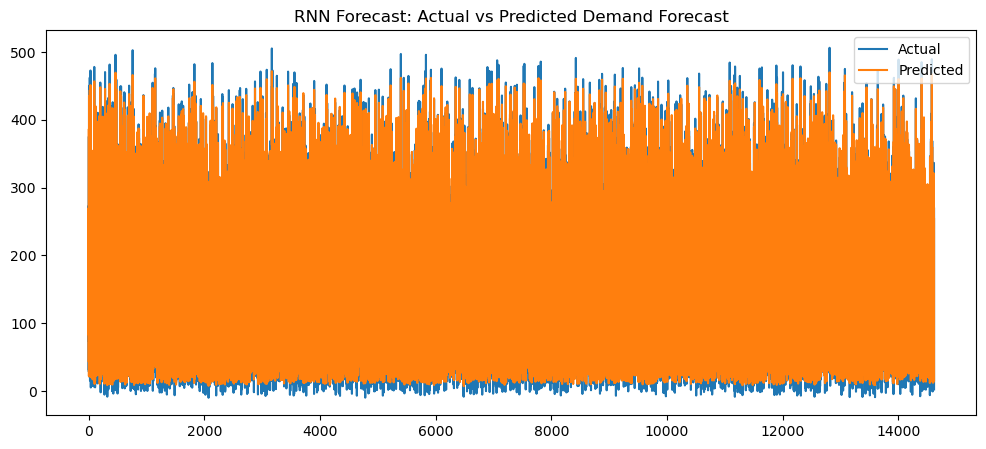

In [19]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('RNN Forecast: Actual vs Predicted Demand Forecast')
plt.show()

In [20]:
threshold = 200

y_test_class = (y_test > threshold).astype(int)
y_pred_class = (y_pred > threshold).astype(int)

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, auc
import matplotlib.pyplot as plt

threshold = 200

y_test_class = (y_test > threshold).astype(int)
y_pred_class = (y_pred > threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))

Confusion Matrix:
[[10699    45]
 [  221  3655]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10744
           1       0.99      0.94      0.96      3876

    accuracy                           0.98     14620
   macro avg       0.98      0.97      0.98     14620
weighted avg       0.98      0.98      0.98     14620



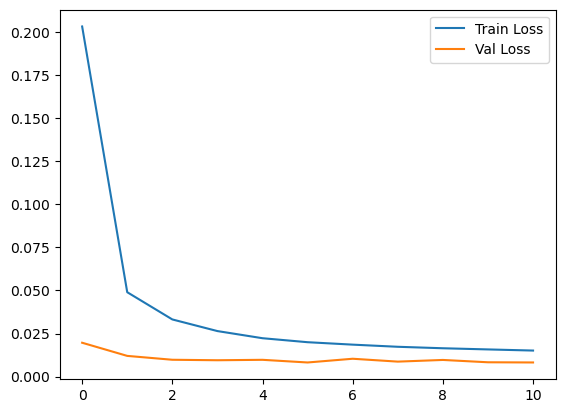

In [22]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()